In [19]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

In [20]:
# Paths
project_root = r"C:/Graduation Project/AI_Cybersecurity"
processed_path = os.path.join(project_root, "Data", "Processed")
models_path = os.path.join(project_root, "Models")

In [21]:
# Load preprocessed data
iso_preds = joblib.load(os.path.join(models_path, "iso_preds.pkl"))
autoencoder = load_model(
    os.path.join(models_path, "autoencoder.keras"),
    custom_objects={"mse": MeanSquaredError()}
)
ae_preds  = joblib.load(os.path.join(models_path, "ae_preds.pkl"))   #reconstruction errors
y_test    = joblib.load(os.path.join(processed_path, "test_labels.pkl"))

In [ ]:
print(pd.Series(y_test).value_counts())
print(pd.Series(y_test).value_counts(normalize=True))

# Normal: 0   
# Attack: 1 
# Both classes are balanced and therefore accuracy is reliable   


1.0    424704
0.0    409643
Name: count, dtype: int64
1.0    0.509026
0.0    0.490974
Name: proportion, dtype: float64


In [35]:
# Load saved models
iso_model = joblib.load(os.path.join(models_path, "iso_model.pkl"))
autoencoder = load_model(
    os.path.join(models_path, "autoencoder.keras"),
    custom_objects={"mse": MeanSquaredError()}
)
ae_threshold = joblib.load(os.path.join(models_path, "ae_threshold.pkl"))

ae_preds_binary = (ae_preds > ae_threshold).astype(int)  #Actual binary predictions from autoencoder based on threshold
iso_preds_converted = np.where(iso_preds == -1, 1, 0)

In [36]:
# Ensemble predictions

# AND voting (anomaly only if BOTH models say anomaly)
ensemble_and = ((iso_preds_converted == 1) & (ae_preds_binary == 1)).astype(int)

# OR voting (anomaly if EITHER model says anomaly)
ensemble_or  = ((iso_preds_converted == 1) | (ae_preds_binary == 1)).astype(int)



=== AND Voting Ensemble ===
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92    409643
         1.0       0.94      0.90      0.92    424704

    accuracy                           0.92    834347
   macro avg       0.92      0.92      0.92    834347
weighted avg       0.92      0.92      0.92    834347



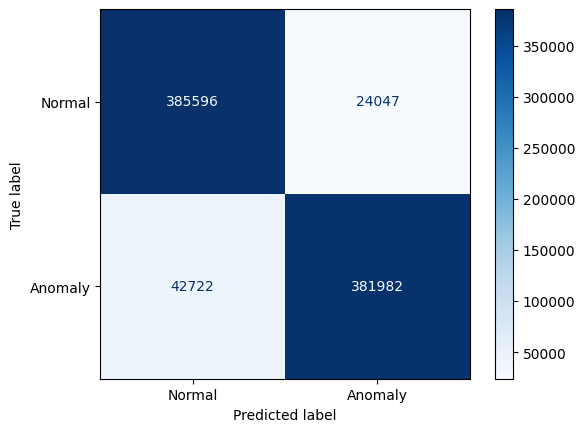

In [37]:
print("\n=== AND Voting Ensemble ===")
print(classification_report(y_test, ensemble_and))
cm = confusion_matrix(y_test, ensemble_and)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()


=== OR Voting Ensemble ===
              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90    409643
         1.0       0.86      0.98      0.92    424704

    accuracy                           0.91    834347
   macro avg       0.92      0.91      0.91    834347
weighted avg       0.92      0.91      0.91    834347



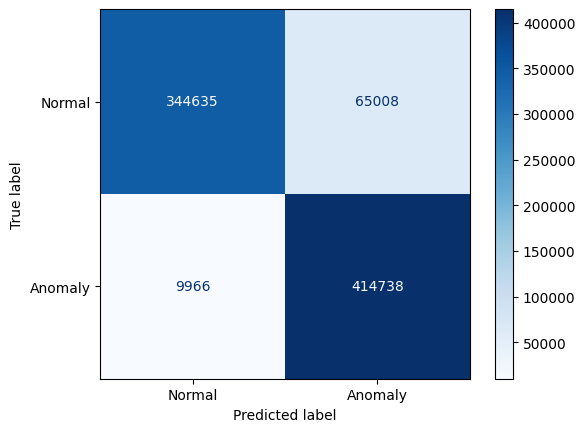

In [38]:
print("\n=== OR Voting Ensemble ===")
print(classification_report(y_test, ensemble_or))
cm_or = confusion_matrix(y_test, ensemble_or)
disp_or = ConfusionMatrixDisplay(confusion_matrix=cm_or, display_labels=["Normal", "Anomaly"])
disp_or.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [39]:
print(type(iso_preds_converted))
print(type(ae_preds_binary))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


=== Weighted Ensemble Report ===
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95    409643
         1.0       0.93      0.97      0.95    424704

    accuracy                           0.95    834347
   macro avg       0.95      0.95      0.95    834347
weighted avg       0.95      0.95      0.95    834347



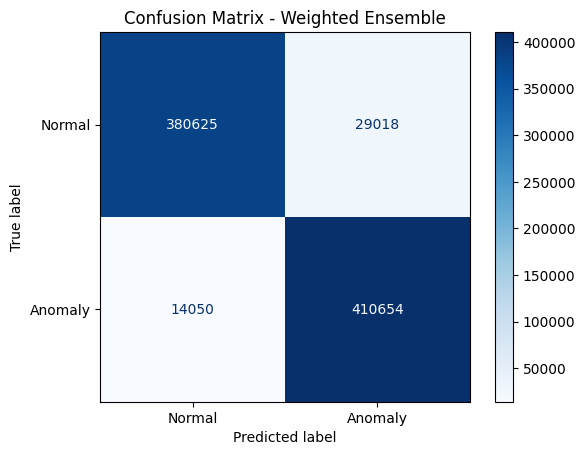

In [46]:
w_iso = 0.6
w_ae  = 0.4
ensemble_score = w_iso * iso_preds_converted + w_ae * ae_preds_binary
ensemble_weighted = (ensemble_score >= 0.5).astype(int)
print("=== Weighted Ensemble Report ===")
print(classification_report(y_test, ensemble_weighted))

cm_weighted = confusion_matrix(y_test, ensemble_weighted)
disp_weighted = ConfusionMatrixDisplay(confusion_matrix=cm_weighted, display_labels=["Normal", "Anomaly"])
disp_weighted.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Weighted Ensemble")
plt.show()

In [47]:
from sklearn.metrics import classification_report
print("Isolation Forest report:\n", classification_report(y_test, iso_preds_converted))
print("Autoencoder report:\n", classification_report(y_test, ae_preds_binary))

Isolation Forest report:
               precision    recall  f1-score   support

         0.0       0.96      0.93      0.95    409643
         1.0       0.93      0.97      0.95    424704

    accuracy                           0.95    834347
   macro avg       0.95      0.95      0.95    834347
weighted avg       0.95      0.95      0.95    834347

Autoencoder report:
               precision    recall  f1-score   support

         0.0       0.90      0.85      0.88    409643
         1.0       0.87      0.91      0.89    424704

    accuracy                           0.88    834347
   macro avg       0.88      0.88      0.88    834347
weighted avg       0.88      0.88      0.88    834347



In [48]:
ensemble_df = pd.DataFrame({
    "iso_preds": iso_preds_converted,
    "ae_preds": ae_preds_binary,
    "AND": ensemble_and,
    "OR": ensemble_or,
    "Weighted": ensemble_weighted,
    "Weighted_score": ensemble_score,
    "y_true": y_test
})

In [49]:
ensemble_df["iso_correct"] = (ensemble_df["iso_preds"] == ensemble_df["y_true"]).astype(int)
ensemble_df["ae_correct"]  = (ensemble_df["ae_preds"] == ensemble_df["y_true"]).astype(int)
ensemble_df["AND_correct"] = (ensemble_df["AND"] == ensemble_df["y_true"]).astype(int)
ensemble_df["OR_correct"]  = (ensemble_df["OR"] == ensemble_df["y_true"]).astype(int)
ensemble_df["Weighted_correct"] = (ensemble_df["Weighted"] == ensemble_df["y_true"]).astype(int)

In [50]:
ensemble_df.to_pickle(os.path.join(processed_path, "ensemble_preds.pkl"))
ensemble_df.to_csv(os.path.join(processed_path, "ensemble_preds.csv"), index=False)